In [1]:
import kgen,PyCO2SYS,numpy
from matplotlib import pyplot

# Create a cubic grid
number_of_points = 11
temperature_range = numpy.linspace(10,40,number_of_points)
salinity_range = numpy.linspace(30,40,number_of_points)
pressure_range = numpy.linspace(0,1000,number_of_points)

temperature_grid,salinity_grid,pressure_grid = numpy.meshgrid(temperature_range,salinity_range,pressure_range)

# Flatten the grid into arrays to go into pyco2sys and kgen
temperature_flat = numpy.ravel(temperature_grid)
salinity_flat = numpy.ravel(salinity_grid)
pressure_flat = numpy.ravel(pressure_grid)

# Specify the grid index of the reference point
# Have chosen the one closest to modern
standard_index = [5,5,0]

# Taken directly from PyCO2SYS examples, most values irrelevant as just using this as a vehicle to get K*'s
# Define input conditions
pyco2sys_input = dict(
    par1 = 2400,  # Value of the first parameter
    par2 = 2300,  # Value of the second parameter, which is a long vector of different DIC's!
    par1_type = 1,  # The first parameter supplied is of type "1", which is "alkalinity"
    par2_type = 2,  # The second parameter supplied is of type "2", which is "DIC"
    salinity = salinity_flat,  # Salinity of the sample
    temperature = temperature_flat,  # Temperature at input conditions
    opt_k_carbonic = 10,  # Have chosen these to match up with kgen (hopefully)
    opt_k_bisulfate = 1,
    opt_k_fluoride = 2,
    pressure = pressure_flat*10 # PRESSURE IN DBAR
)

# Get the results
pyco2sys_results = PyCO2SYS.sys(**pyco2sys_input)
kgen_results = kgen.calc_Ks(temp_c=temperature_flat,sal=salinity_flat,p_bar=pressure_flat)

# Give the names for each K*
pyco2sys_k_names = ["k_CO2","k_carbonic_1","k_carbonic_2","k_water","k_borate","k_fluoride","k_bisulfate","k_phosphoric_1","k_phosphoric_2","k_phosphoric_3","k_silicate","k_calcite","k_aragonite"]
kgen_k_names = ["K0","K1","K2","KW","KB","KF","KS","KP1","KP2","KP3","KSi","KspC","KspA"]

# Iterate over each K* to calculate the diffence between kgen and pyco2sys as a percentage (using kgen as the reference)
# Gets reshaped into the cubic grid so it can be easily sliced
difference = dict()
for pyco2sys_name,kgen_name in zip(pyco2sys_k_names,kgen_k_names,strict=True):
    pyco2sys_grid = numpy.reshape(pyco2sys_results[pyco2sys_name],(number_of_points,number_of_points,number_of_points))
    kgen_grid = numpy.reshape(kgen_results[kgen_name],(number_of_points,number_of_points,number_of_points))
    difference[kgen_name] = 100*(pyco2sys_grid-kgen_grid)/kgen_grid

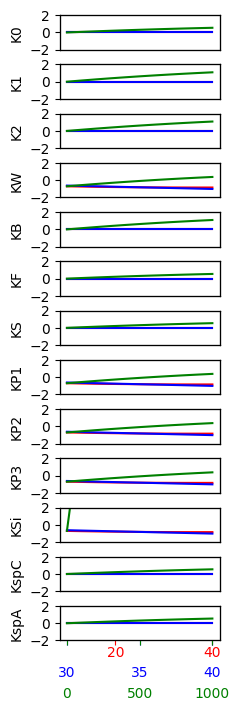

In [2]:
# Create a figure
figure = pyplot.figure(figsize=(4,8))
axes = []

# Height of each axis to divide the vertical space equally
height = (0.9-0.1)/len(kgen_k_names)

for index,k in enumerate(kgen_k_names.__reversed__()):
    # Plot the difference along a temperature slice
    current_axis = pyplot.axes((0.3,0.1+index*(height),0.4,height*0.7))
    current_axis.plot(temperature_range,difference[k][standard_index[1],:,standard_index[2]],color="red")
    current_axis.set_ylim((-2,2))
    current_axis.set_ylabel(k)
    current_axis.set_facecolor("#00000000")
    current_axis.tick_params(axis="x",colors="red",pad=0)
    if index>0:
        current_axis.set_xticks(())

    # Plot the difference along a salinity slice
    current_axis = pyplot.axes((0.3,0.1+index*(height),0.4,height*0.7))
    current_axis.plot(salinity_range,difference[k][:,standard_index[1],standard_index[2]],color="blue")
    current_axis.set_ylim((-2,2))
    current_axis.set_yticks(())
    current_axis.set_facecolor("#00000000")
    current_axis.tick_params(axis='x',which='major',pad=15,colors="blue")
    if index>0:
        current_axis.set_xticks(())
    
    # Plot the difference along a pressure slice
    current_axis = pyplot.axes((0.3,0.1+index*(height),0.4,height*0.7))
    current_axis.plot(pressure_range,difference[k][standard_index[1],standard_index[2],:],color="green")
    current_axis.set_ylim((-2,2))
    current_axis.set_yticks(())
    current_axis.set_facecolor("#00000000")
    current_axis.tick_params(axis='x',which='major',pad=30,colors="green")
    if index>0:
        current_axis.set_xticks(())
